# Modeling Analysis: Predicting token profitability

## 1. Introduction

This notebook investigates early-stage metrics of newly launched tokens on the Solana blockchain 
and tries to understand why a token is likely to become profitable ('worth it'). 

The target variable, `IsWorthIt`, is engineered in the preprocessing pipeline and is based on 
price behavior within a defined timeframe post-launch. This notebook imports pre-built functions 
for data ingestion, preprocessing, and target assignment to ensure consistency with the overall 
Dexboost architecture.

The objective here is to evaluate the predictive power and significance of selected non-leaky features, 
such as Market Capitalization and Token Age at launch time, using robust tree-based models 
like XGBoost and Random Forest. SHAP (SHapley Additive exPlanations) is used to interpret 
the contribution of each feature to the model’s predictions.

This approach helps validate earlier assumptions from the exploratory analysis phase, and allows us 
to quantify the influence of early metrics on token success likelihood.

## 2. Imports

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import xgboost as xgb
import shap

import sys
import os
sys.path.append(os.path.abspath("."))
sys.path.append(os.path.abspath("../"))  # Go up one directory level
from env_scripts.pipeline import load_and_filter_data, process_price_data, summarize_token_behavior
from env_scripts.db_utils import connect_db, close_connection
from env_scripts.parameter_utils import suggest_token_filters, write_filters_to_parameters_file


## 3. Preparing data for analysis

We will use functions from the existing dexboost pipeline to:

    1. Connect to the database
    2. Load raw data
    3. Parse price history column
    4. Summarize each token's behavior (producing IsWorthIt variable as the main target)

Once we have the data ready, we will prepare the models to evaluate significance of each variable and try to explain IsWorthIt.

In [27]:
conn = connect_db("C:/Users/Laú/Desktop/shitcoins_data/main_backup.db") # Adjust path as needed
df_raw = load_and_filter_data(conn, days_back=None) # Adjust days back if needed, whole dataset is included with None. I prefer to analyze the whole dataset first.
df_clean, df_prices = process_price_data(df_raw)
df_summary = summarize_token_behavior(df_prices)
close_connection(conn)

Analyzing all available data
[1] After DetectedAt parsed: (1558, 13)
[2] After non-empty PriceHistory: (1558, 13)
[3] After valid JSON list: (1531, 13)
[4] After valid PriceTime: (2320519, 15)
[5] After TimeSync filter: (2210878, 15)
[6] Final price table shape: (2210878, 18)


## 4. Model set up

In this section, we prepare the data for training a classification model to predict whether a token is considered "worth it" based on its characteristics at detection time. To avoid data leakage, we only include features available *before* any price movement occurs. This ensures the model could realistically be used in a live setting. Since I created 

The selected features are:

- **MarketCap**: Initial market capitalization at detection
- **TotalLiquidity**: Liquidity available at the time of detection
- **Amount**: Total supply of the token
- **RugScore**: Risk indicator based on token and contract characteristics
- **TokenAge**: Age of the token in minutes
- **IsPump**: Binary indicator if the token is marked as pump
- **TotalLPProviders**: Number of liquidity providers

These variables are known at detection time and do not depend on future information such as price movement, variation, or trigger events.


In [28]:
# Merge df_clean with df_summary on TokenMint to ensure alignment
df_model = df_clean.merge(df_summary[['TokenMint', 'IsWorthIt']], on='TokenMint', how='inner')

# Features and target
features = ['MarketCap', 'TotalLiquidity', 'Amount', 'RugScore', 'TokenAge', 'TotalLPProviders', 'IsPump']
X = df_model[features]
y = df_model['IsWorthIt']

# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

# XGBoost Classifier training
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)


c:\Python\my_projects\dexboost\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:43:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

## 5. Evaluation

We will evaluate the classifier using standard metrics, such as classification report, confusion matrix, ROC-AUC and we also plot the ROC curve.

🔍 Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.74      0.73       276
           1       0.54      0.51      0.53       166

    accuracy                           0.65       442
   macro avg       0.63      0.63      0.63       442
weighted avg       0.65      0.65      0.65       442



C:\Users\Laú\AppData\Local\Temp\ipykernel_15340\3911953398.py:23: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) Arial.
  plt.tight_layout()
c:\Python\my_projects\dexboost\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


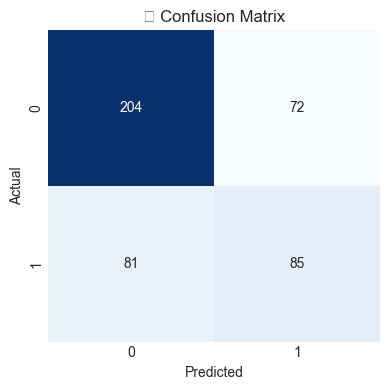

C:\Users\Laú\AppData\Local\Temp\ipykernel_15340\3911953398.py:37: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
c:\Python\my_projects\dexboost\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


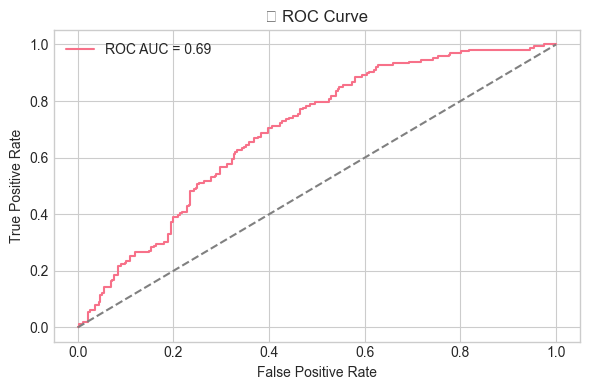

C:\Users\Laú\AppData\Local\Temp\ipykernel_15340\3911953398.py:50: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from font(s) Arial.
  plt.tight_layout()
c:\Python\my_projects\dexboost\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


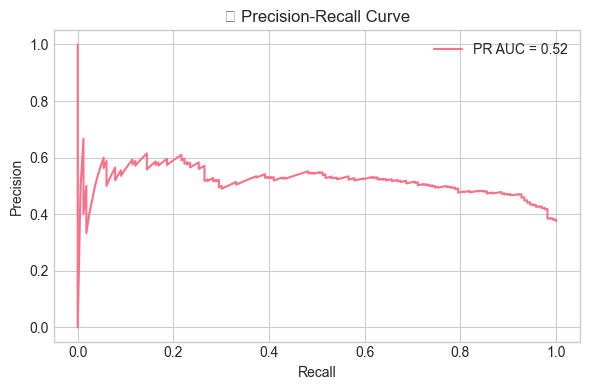

Test Set Class Distribution: [276 166]


In [29]:
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve,
    precision_recall_curve, average_precision_score
)
import seaborn as sns
import matplotlib.pyplot as plt

# Predict labels and probabilities
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Classification Report
print("🔍 Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("🧩 Confusion Matrix")
plt.tight_layout()
plt.show()

# ROC Curve
roc_auc = roc_auc_score(y_test, y_proba)
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('📈 ROC Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_proba)
pr_auc = average_precision_score(y_test, y_proba)
plt.figure(figsize=(6, 4))
plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('🔁 Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Class distribution
print(f"Test Set Class Distribution: {np.bincount(y_test)}")


**FIRST EVALUATION**

We evaluate the performance of our initial XGBoost classifier using several key metrics:

**Classification Report**: Provides precision, recall, and F1-score for both classes.
The model shows better performance predicting non-worthwhile tokens (class 0) than worthwhile ones (class 1), which is expected due to class imbalance and the inherent challenge in identifying profitable tokens early.

**Confusion Matrix**: Visual insight into the distribution of true/false positives and negatives.

**ROC Curve**: AUC of 0.69 indicates moderate separability. While not outstanding, it suggests the model captures some predictive signal.

**Precision-Recall Curve**: Especially relevant due to class imbalance. PR AUC of 0.52 indicates room for improvement, particularly in terms of precision when recall is high.

**Test set distribution**: The test set contains 276 class 0 and 166 class 1 tokens.

Overall, the model shows promising baseline performance and sets the stage for further improvement via hyperparameter tuning and feature engineering.

## 6. Feature Importance & SHAP

In this section, we analyze which variables drive the model's decisions using both the built-in XGBoost importance and SHAP values. SHAP provides a more nuanced, model-agnostic view that helps validate whether the model relies on reasonable patterns. We also generate token filter suggestions based on the most influential features.


C:\Users\Laú\AppData\Local\Temp\ipykernel_15340\687971513.py:13: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) Arial.
  plt.tight_layout()


<Figure size 800x600 with 0 Axes>

c:\Python\my_projects\dexboost\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


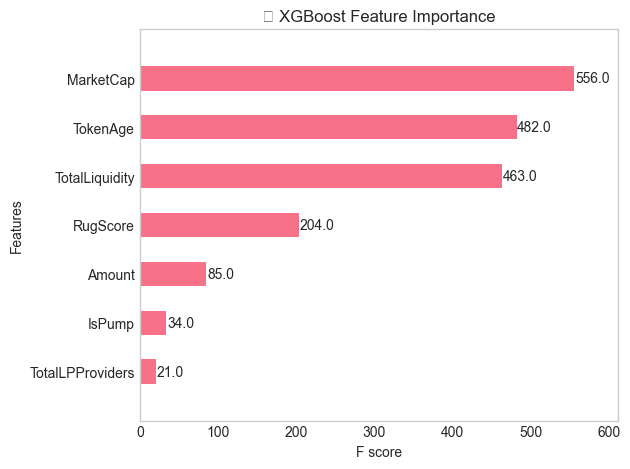

TypeError: Cannot cast array data from dtype('O') to dtype('float64') according to the rule 'safe'

In [30]:
import shap
import xgboost as xgb
import matplotlib.pyplot as plt

# Asegurarse de que todas las columnas sean numéricas
X_train = X_train.apply(pd.to_numeric, errors='coerce')
X_test = X_test.apply(pd.to_numeric, errors='coerce')

# 1. XGBoost built-in feature importance
plt.figure(figsize=(8, 6))
xgb.plot_importance(model, height=0.5, grid=False)
plt.title("🧠 XGBoost Feature Importance")
plt.tight_layout()
plt.show()

# 2. SHAP Explanation (global interpretability)
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

# SHAP summary plot: muestra impacto y dirección de cada variable
shap.summary_plot(shap_values, X_test, show=True)

# SHAP waterfall plot: explica una predicción específica
shap.plots.waterfall(shap_values[0], max_display=10)



### 🔍 SHAP Interpretation Overview

These SHAP plots help us understand how the model is making decisions — both overall (global view) and for a specific token (local view).

#### 📊 XGBoost Feature Importance
This chart shows how often each feature was used to make splits in the decision trees. It tells us which variables the model "looked at" the most, but not how they actually influenced the result.

#### 🌍 SHAP Summary Plot (Global)
Each dot is one token from the test set.  
- **Red dots** mean high values for that feature, **blue dots** are low values.  
- If the dot is on the right, that feature pushed the prediction **closer to 1** (a "worth it" token).  
- If it's on the left, it pushed it **closer to 0** (not worth it).  
This plot helps us see how each feature behaves across all predictions.

#### 👁 SHAP Waterfall Plot (Local)
This one is for a single token.  
It starts from the **base value** (average prediction of the model), and then shows how each feature pushes the prediction up or down.  
It's like the model saying:  
*"Because this token had a low amount of liquidity and a high token age, I think it's more likely to be worth it."*

#### ⚠️ Notes
The suggested filters we generated earlier were based on SHAP values, but they might be too strict.  
In practice, it's better to **use SHAP to validate** which variables matter and then **decide filters manually** based on intuition and EDA.



From the results, we confirm that `TokenAge`, `TotalLiquidity`, and `MarketCap` are the most impactful features.



## 7. Hyperparameter tuning (RandomizedSearchCV)

Now that we have trained a baseline XGBoost model and evaluated its performance, we'll attemps to improve it by using RandommizedSearchCV to explore different combinations and validate results. This will allow us to find a better configuration without exhaustively searching the entire space like in GridSeatchCV.

In [ ]:
# 7. Hyperparameter Tuning with RandomizedSearchCV

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
import time

# Parameter space for XGBoost
param_dist = {
    'n_estimators': randint(100, 1000),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'gamma': uniform(0, 5)
}

# Base model
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Randomized Search with 3-fold CV
random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_dist,
    n_iter=100,
    scoring='f1',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit and time the tuning
start = time.time()
random_search.fit(X_train, y_train)
end = time.time()

# Best results
print("\n✅ Best hyperparameters found:")
print(random_search.best_params_)

print(f"\n⏱️ Search completed in {(end - start):.2f} seconds.")


Fitting 3 folds for each of 100 candidates, totalling 300 fits

✅ Best hyperparameters found:
{'colsample_bytree': np.float64(0.8801431319891084), 'gamma': np.float64(4.233305711191529), 'learning_rate': np.float64(0.26689728756342773), 'max_depth': 8, 'n_estimators': 219, 'subsample': np.float64(0.9551080395043839)}

⏱️ Search completed in 3.57 seconds.


c:\Python\my_projects\dexboost\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:33:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


## 8. Evaluation of tuned model

In this section, we train a new XGBoostClassifier using the best hyperparameters found through RandomizedSearchCV. Then, we evaluate the model with metrics such as classification report, confusion matrix, and ROC AUC. The ROC curve gives a visual overview of the model's ability to separate the two classes.

Although the dataset is noisy and we have limited features, the tuned model achieves an AUC of 0.70, which is a decent improvement compared to the initial baseline. This means the model is somewhat effective at identifying tokens that are likely to perform well shortly after launch.

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.68      0.71       276
           1       0.53      0.60      0.56       166

    accuracy                           0.65       442
   macro avg       0.64      0.64      0.64       442
weighted avg       0.66      0.65      0.66       442

🔎 Confusion Matrix:
[[188  88]
 [ 66 100]]
📈 ROC AUC Score: 0.705


C:\Users\Laú\AppData\Local\Temp\ipykernel_15340\128018573.py:41: UserWarning: Glyph 128678 (\N{VERTICAL TRAFFIC LIGHT}) missing from font(s) Arial.
  plt.tight_layout()
c:\Python\my_projects\dexboost\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128678 (\N{VERTICAL TRAFFIC LIGHT}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


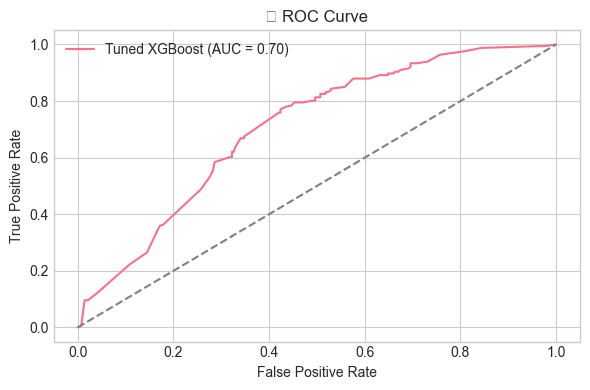

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Train tuned model with best hyperparameters
tuned_model = xgb.XGBClassifier(
    colsample_bytree=0.88,
    gamma=4.23,
    learning_rate=0.27,
    max_depth=8,
    n_estimators=219,
    subsample=0.96,
    eval_metric='logloss',
    random_state=42
)

tuned_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = tuned_model.predict(X_test)
y_proba = tuned_model.predict_proba(X_test)[:, 1]

print("📊 Classification Report:")
print(classification_report(y_test, y_pred))

print("🔎 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# ROC-AUC
roc_auc = roc_auc_score(y_test, y_proba)
print(f"📈 ROC AUC Score: {roc_auc:.3f}")

fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'Tuned XGBoost (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('🚦 ROC Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 9. Random Forest Validation

📊 Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.73      0.72       276
           1       0.52      0.48      0.50       166

    accuracy                           0.64       442
   macro avg       0.61      0.61      0.61       442
weighted avg       0.63      0.64      0.64       442

🔎 Confusion Matrix:
[[202  74]
 [ 86  80]]
📈 ROC AUC Score (RF): 0.694


C:\Users\Laú\AppData\Local\Temp\ipykernel_15340\1581700501.py:32: UserWarning: Glyph 127794 (\N{EVERGREEN TREE}) missing from font(s) Arial.
  plt.tight_layout()
c:\Python\my_projects\dexboost\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127794 (\N{EVERGREEN TREE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


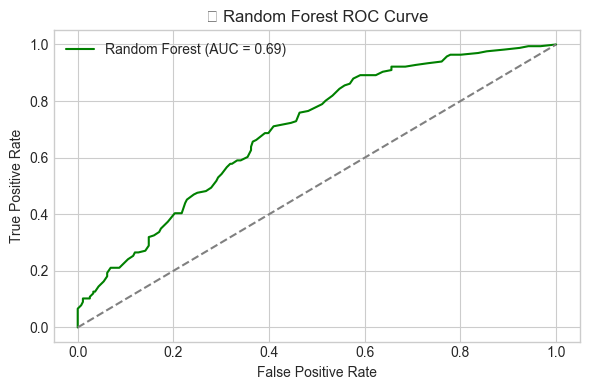

C:\Users\Laú\AppData\Local\Temp\ipykernel_15340\1581700501.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='Greens_r')
C:\Users\Laú\AppData\Local\Temp\ipykernel_15340\1581700501.py:49: UserWarning: Glyph 127794 (\N{EVERGREEN TREE}) missing from font(s) Arial.
  plt.tight_layout()
c:\Python\my_projects\dexboost\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127794 (\N{EVERGREEN TREE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


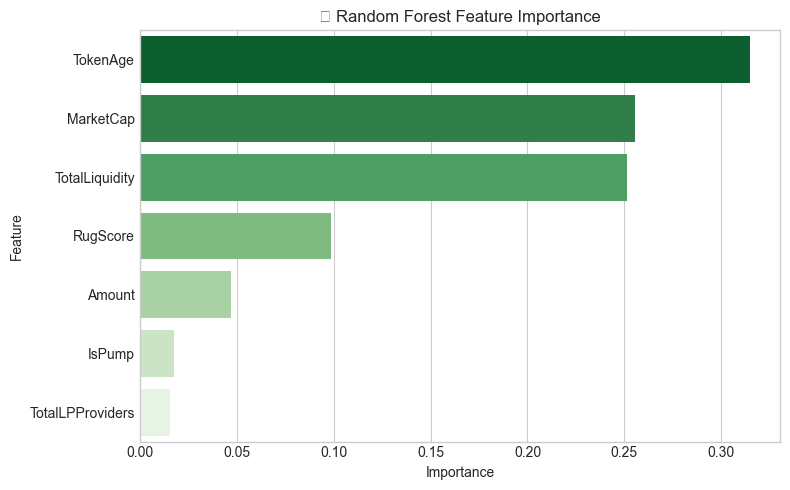

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# 9. Random Forest Baseline (to validate XGBoost)
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

print("📊 Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

print("🔎 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

# ROC-AUC
roc_auc_rf = roc_auc_score(y_test, y_proba_rf)
print(f"📈 ROC AUC Score (RF): {roc_auc_rf:.3f}")

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
plt.figure(figsize=(6, 4))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.2f})', color='green')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('🌲 Random Forest ROC Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Get feature importances from Random Forest
importances = rf_model.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for easy plotting
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='Greens_r')
plt.title('🌲 Random Forest Feature Importance')
plt.tight_layout()
plt.show()

## 9. 🎯 Conclusion

After tuning and validating our model, we end up with a reasonable classifier to help distinguish potentially good tokens from risky ones in a highly volatile environment like Solana DEX listings.

### ✅ Key Takeaways:

- **XGBoost outperformed Random Forest** slightly in terms of ROC AUC (0.70 vs 0.69), and offered better F1-score for the positive class (`IsWorthIt == 1`), which is the main interest for short-term trading opportunities.
- Both models **agree on the most important features**: `MarketCap`, `TokenAge`, and `TotalLiquidity`. This reinforces confidence in the significance of early token metrics.
- **SHAP plots gave us solid interpretability**, showing not just which features matter most, but *how* they influence predictions — very useful for understanding individual token behavior.
- Automatic filters from SHAP were generated, but seemed too strict. For now, we’ll rely more on **EDA + SHAP insights** rather than fixed thresholds.

---

### 🔧 Model status

This notebook now includes:

1. A full ML pipeline (data cleaning → training → evaluation → interpretation)  
2. Two different models for **cross-validation of insights**  
3. Optional SHAP-based logic for further filtering  
4. A strong base for future real-time deployment  

---

### 🚀 What’s next?

If we want to push this further:

- 🎯 **Threshold tuning** to improve precision/recall depending on strategy (conservative vs aggressive)  
- 🧪 Use **Bayesian Optimization** to fine-tune hyperparameters better  
- 🧠 Add more features like volatility, volume trends, or even tweet-based hype metrics  
- 🧩 Export model to `.pkl` and integrate it into the DexBoost pipeline for real-time scoring  
- ⏳ Implement **time-based validation** to reflect changing market dynamics  


